# KISNET - Sylt-List groundwater flow model

* Larger scale steady-state constant density model

* Aim: Estimate principal flow pattern, and fresh and tidally recirculated saline submarine discharge

* We use MODFLOW 2005 and operate in Flopy


In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd  ### note to plot shape files with geopandas, you need the package descartes
from rasterio.plot import show
from rasterio import features
from rasterio.enums import Resampling
from scipy.signal import medfilt2d
import pandas as pd
import flopy

flopy is installed in /home/janek/.local/lib/python3.6/site-packages/flopy


In [2]:
#plt.switch_backend('nbAgg')
%matplotlib inline

## 1. Preparation of a raster of flags for assignment of flow boundary conditions

+ Vertical no-flow boundary somewhat below the low tide mark, i.e., boundary of model domain

+ 3rd type boundary in the intertidal zone, approximate tide averaged hydraulic heads

+ Annual groundwater recharge
 + DWD precipitation data minus DWD FAO Penman-Monteith evapotranspiration data  

#### You can click on Assemble model to skip Chapter 1, if files from Github haven been pulled.
<a href='#assemble_model'>Assemble model</a>

#### Topography and Bathymetry data from https://mdi-de.baw.de/easygsh/index.html

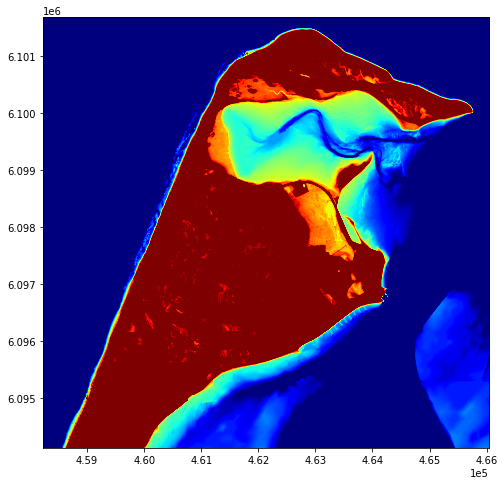

In [3]:
rst=rasterio.open('./Bathymetrie_sub.tif') ### topography on 10m x 10m grid
fig, ax = plt.subplots(1, figsize=(8, 8))
show(rst.read(),transform=rst.transform,ax=ax,vmin=-2,vmax=2,cmap='jet')

#### We want a 20m x 20m raster 

In [7]:
## resample 
upscale_factor = 0.5 ## 0.5 = coarsen the grid 

with rasterio.open("Bathymetrie_sub.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

#### Smooth it to get rid of unrealistic spikes in the intertidal zone, and save it

In [8]:
## smooth it to get rid of sharp edges
topo_new=medfilt2d(data[0,:,:],kernel_size=3)

## replace old meta data with new
meta=rst.meta.copy()
meta['transform']=transform
meta['height']=np.shape(topo_new)[0]
meta['width']=np.shape(topo_new)[1]

## save the new resampled and smoothed topo
with rasterio.open('./Bathymetrie_sub_resampled.tif','w', **meta) as out:
 out.write_band(1,topo_new)

#### Reopen the smoothed dataset and load in shape files from QGIS
+ The shape files define areas where cells should be active, inactive and should receive a seaside (3rd type) boundary
+ A raster of corresponding flags is saved to be used for Modflow IBOUNDS in flopy:
 * 0: inactive
 + 1: active
 + 2 and 3: cells in the inland below high tide that should not get a sea boundary

In [4]:
## open the new topo 
rst2=rasterio.open('./Bathymetrie_sub_resampled.tif')

## open the shape from QGIS: id values of polygons: 1 is active cell area, 2 and 3 are zones that 
## contain heights in the inland that are below high tide mark, i.e., they will not receive GHB or DRN
shp=gpd.read_file('./Active_cells.shp')

## convert polygon ids to int 
meta2=rst2.meta.copy()
meta2['dtype']='int16'

## rasterize the shape and make a raster of flags the same format (size and resolution) as the resampled topo
with rasterio.open('./active_cells.tif','w+', **meta2) as out:
 out_arr=out.read(1)   
 shapes = ((geom,value) for geom, value in zip(shp.geometry, shp.id))
 flag_raster=features.rasterize(shapes=shapes,fill=0,out=out_arr,transform=out.transform)
 out.write_band(1,flag_raster)


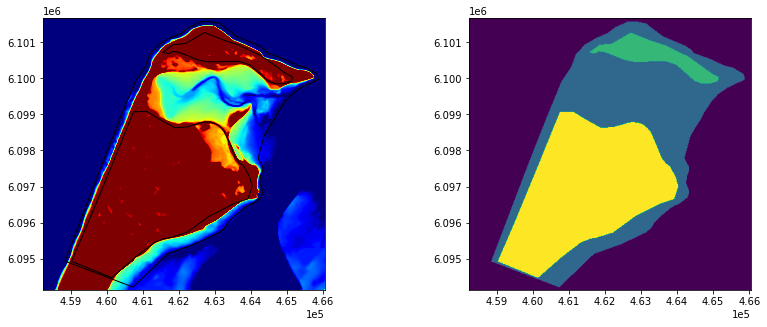

In [5]:
## plot the stuff
fig=plt.figure(1,figsize=(14, 5))
ax = plt.subplot(1,2,1)
show(rst2.read(),transform=rst2.transform,ax=ax,vmin=-2,vmax=2,cmap='jet')
shp.plot(facecolor="none", edgecolor='black',ax=ax)
rst3=rasterio.open('./active_cells.tif') 
ax2 = plt.subplot(1,2,2)
show(rst3.read(),transform=rst3.transform,ax=ax2)


## 2. Setting up the model

### Figure from Dissertation of Lindhorst 2008: http://ediss.sub.uni-hamburg.de/volltexte/2008/3611/ 

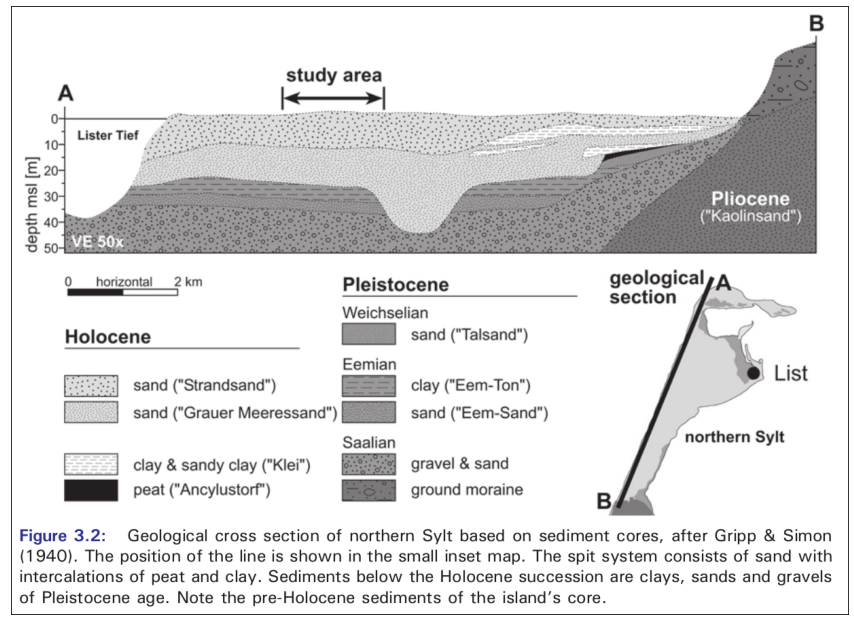

In [13]:
lindhorst_fig=plt.imread('./figs/Cross_section_Fig_3.2__Lindhorst_2008.png')
fig=plt.figure(1,figsize=(15,15)) 
img=plt.imshow(lindhorst_fig)
img.axes.get_xaxis().set_visible(False)
img.axes.get_yaxis().set_visible(False)

+ Assumtion based on crossection: Continueous clay layer at 25 m below mean sealevel
+ Neglection of the geological window in the middel of the profile
+ Set of aquifer base at 25 m below mean sea level
+ For the time beeing we assumed a homogeneous hydraulic conductivity with Kh = 20 m/d and Kv:Kh = 1:2

<a id='assemble_model'></a>
### Assemble model

In [4]:
rst2=rasterio.open('./Bathymetrie_sub_resampled.tif')
top=np.copy(rst2.read()[0]) # get topography

nrow=len(top[:,1]) # number of model rows
ncol=len(top[1,:]) # number of model columns
nlay=10 # number of model layers


rst3=rasterio.open('./active_cells.tif')
flag_raster=np.copy(rst3.read()[0])

ibound=np.broadcast_to(flag_raster,(nlay,nrow,ncol)) # broadcast the ibounds to all layers

In [6]:
# Here we make the bottoms for each layer
# We want to make the bottom of each cell in the first layer sufficently low that the cell does not become dry
botm=np.zeros((nlay,nrow,ncol))
botm[0,:,:]=top-2.0
botm[botm>0.2]=0.2 # make that the bottom of the top layer is always sufficiently low
botm[-1,:,:]=-25 ## bottem of last layer: base of the aquifer at -25m 

## make equidistant bottoms for the other layers
for j in range(nrow):
  for k in range(ncol):
    botm[1:-1,j,k]=np.linspace(botm[0,j,k],botm[-1,j,k],nlay)[1:-1]


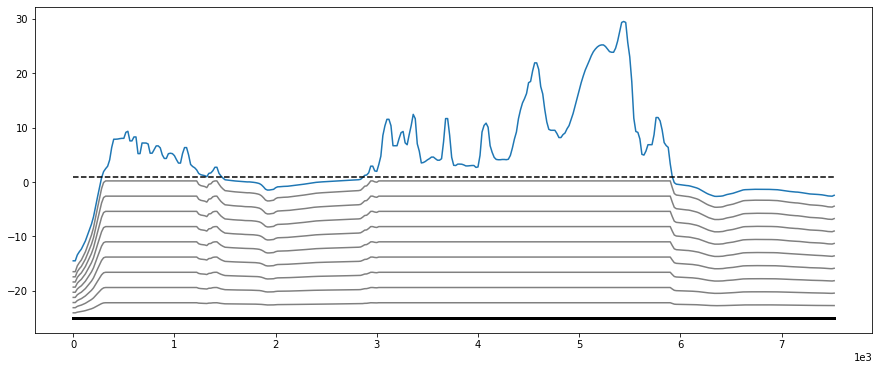

In [7]:
## Check for a cross section (North - South)
dx=rst3.transform[0]
dy=-rst3.transform[4]
dist=np.arange(nrow)*dy # distance in m
fig=plt.figure(1,figsize=(15,6))
plt.plot(dist,top[:,210]) 
for i in range(nlay):
  plt.plot(dist,botm[i,:,210],'-',color='gray') 
plt.plot(dist,botm[-1,:,210],'k-',lw=3) 
plt.plot(dist,np.ones(nrow)*0.9,'k--') # plot dashed line at MThw = 0.9m (see further below)

### Tides
+ Source: https://www.pegelonline.wsv.de/gast/stammdaten?pegelnr=9570070
+  MThw = 0.87, MTnw = -0.92
+ We assume diurnal tides with A = 0.9 m and mean of 0 m asl
+ We put tide average heads in the intertidal zone, i.e. between -0.9m and +0.9m asl
* Analytical solutions by Peter Nielsen and Ling Li do not work for flat beaches
+ So we approximate based on the idea of Alexander Vandenbohede
+ We do not account for the decrease of groundwater level at the high tide mark during low tide
+ The the decrease of groundwater level at the high tide is lower for flatter beaches and lower K
+ So far the effect of waves are neglected

Text(0, 0.5, 'Average hydraulic head')

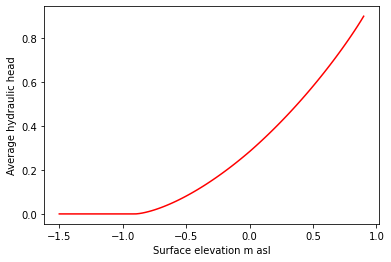

In [8]:
def av_head(A,top):
    t=np.linspace(0,2*np.pi,100)
    sine=A*np.sin(t) # make a tide over one tidal cycle
    sine[sine<top]=top
    return np.mean(sine)

# check
A=0.9
topi=np.linspace(-1.5,0.9,100)
av_h = [av_head(A,ti) for ti in topi]
plt.plot(topi,av_h,'r-')
plt.xlabel('Surface elevation m asl')
plt.ylabel('Average hydraulic head')


In [37]:
## Generate heads for 3rd type boundary condition (Modflow GHB) in the intertidal zone
## Flopy needs a dictionary for the stress periods (we will have only one stress period so far)
## Conductance C at GHB cell is calculated from cell area and distance from nodal elevation to surface elevation, 
## and hydraulic conductivity K:
## C = K * (dx*dy)/(dz/2)

K = 20 # Hydraulic conductivity in m/d
dz_1 = top-botm[0,:,:] # dz of top layer 
ghb_stress=[] # make a list 
for i in range(nrow):
 for j in range(ncol):
   if flag_raster[i,j]==1 and top[i,j]<=0.9: 
    hh=av_head(A,top[i,j])
    ghb_stress.append([0,i,j,hh,K*dx*dy/(dz_1[i,j]/2)]) 

GHB_stress_period_data = {0:ghb_stress} 

### Climate data from DWD (https://opendata.dwd.de/climate_environment/CDC/)
+  Station 3032 Sylt List
+ Daily data until 31-12-2019 
 + Precipitation [mm]
 + ET FAO Penman-Monteith (to be discussed, maybe check mGrowa)


In [2]:
prec_dat=pd.read_csv('./climate_data/produkt_nieder_tag_19310101_20191231_03032.txt',delimiter=';',
                     skipinitialspace=True) 
et_dat=pd.read_csv('./climate_data/derived_germany__soil__daily__historical__3032.txt',delimiter=';',
                  skipinitialspace=True)

In [5]:
prec=np.array(prec_dat['RS'])
et=np.array(et_dat['VPGPM'])

y1=-17 # year back in time from 2019
y2=-2  # year back in time from 2019

Ri=prec[365*y1:365*y2] - et[365*y1:365*y2]
#plt.figure(figsize=(15,15))
#plt.bar(np.arange(len(Ri)),Ri)

#Groundwater recharge, we assume no evaporation from groundwater, i.e. no ET without Precipitation  
Ri[Ri<0]=0
R=np.nansum(Ri)/abs(y1-y2)
print('Mean annual groundwater recharge: %3.0f mm/a' % R) ### 510 mm/a seems high compared to e.g. Spiekeroog

Mean annual groundwater recharge: 510 mm/a


In [8]:
## JG: I think its to high, lets take the Spiekeroog value

R=350.0

Rech=np.zeros((nrow,ncol))
Rech[top>0.9]=R/1000.0/365.0 # m/d ## apply to region above high tide mark

### Flopy

In [43]:
model_name = 'Koenigshafen_0'
mf2005_exe='/home/janek/bin/Chris_Langevin/intel/mf2005'

In [44]:
m=flopy.modflow.Modflow(modelname=model_name,model_ws=model_name,exe_name=mf2005_exe)
dis=flopy.modflow.ModflowDis(m,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,
                             top=top, botm=botm, perlen=1.0, nstp=1, nper=1,steady=True)
bas=flopy.modflow.ModflowBas(m,ibound=ibound,strt=1.0)
pcg=flopy.modflow.ModflowPcg(m, mxiter=500, iter1=300, hclose=1e-4, rclose=0.001)
lpf=flopy.modflow.ModflowLpf(m,laytyp=3,hk=K,vka=K/2,ipakcb=50)
ghb=flopy.modflow.ModflowGhb(m,stress_period_data=GHB_stress_period_data,ipakcb=50)
rch=flopy.modflow.ModflowRch(m,rech=Rech,ipakcb=50)
oc=flopy.modflow.ModflowOc(m,stress_period_data = {(0,0):['save head','save budget']})

m.write_input()

In [45]:
m.run_model()

FloPy is using the following  executable to run the model: /home/janek/bin/Chris_Langevin/intel/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Koenigshafen_0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/06/08 10:39:38

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/06/08 10:39:53
 Elapsed run time: 15.184 Seconds

  Normal termination of simulation


(True, [])

## Results

### Modelled hydraulic heads

(6098500.0, 6100500.0)

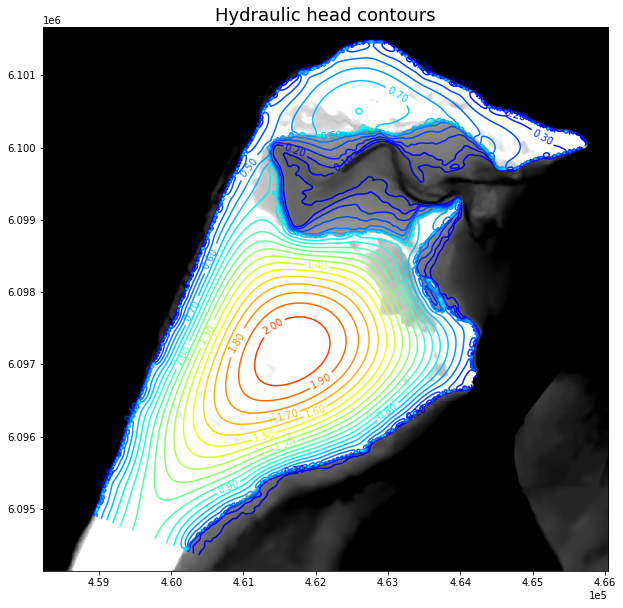

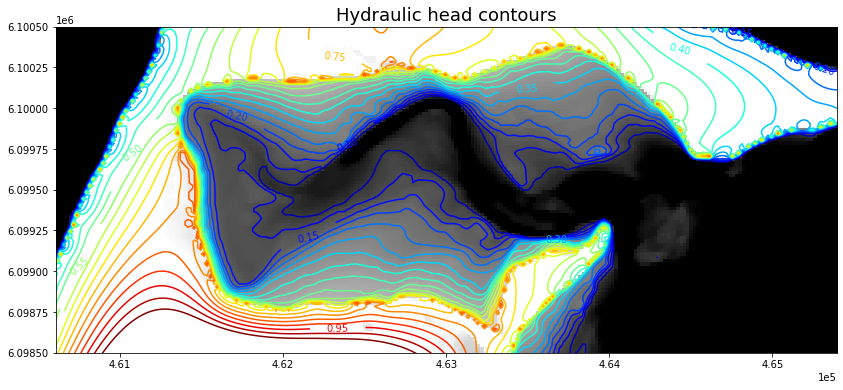

In [96]:
fname = model_name+'/' + model_name+'.hds'
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
head[head<-900]=np.nan
fig, ax = plt.subplots(1, figsize=(14, 10))
show(top,transform=rst3.transform,ax=ax,vmin=-2,vmax=2,cmap='gray')
#show(top,transform=rst2.transform,ax=ax,np.array([0.5]),contour=True)
x0=rst3.transform[2]
y0=rst3.transform[5]
X,Y=np.meshgrid(np.linspace(x0+dx/2,x0+ncol*dx-dx/2,ncol),np.linspace(y0-dy/2,y0-nrow*dy+dy/2,nrow))
#show(head[0,:,:],transform=rst3.transform,ax=ax,vmin=-2,vmax=2,cmap='jet')
cont=plt.contour(X,Y,head[0,:,:],np.arange(-0.1,2.5,0.1),cmap='jet')
#cont=plt.contourf(X,Y,head[0,:,:],np.arange(-0.1,2,0.05),cmap='jet')
plt.clabel(cont,fmt='%1.2f')
plt.title('Hydraulic head contours',fontsize=18)


fig, ax = plt.subplots(1, figsize=(14, 6))
show(top,transform=rst3.transform,ax=ax,vmin=-1.1,vmax=1.1,cmap='gray')
cont=plt.contour(X,Y,head[0,:,:],np.arange(0.0,1.1,0.05),cmap='jet')
plt.clabel(cont,fmt='%1.2f')
plt.title('Hydraulic head contours',fontsize=18)
plt.axis('equal')
plt.xlim(4.61e5,4.65e5)
plt.ylim(6.0985e6,6.1005e6)

### Discussion on modelled hydraulic heads

+ Heads to be checked with real data
+ Tidal overheight (approx. groundwater level at high tide line) needs to be measured
+ Problems close to high tide line: highly undulating topography where we have locally higher beach slopes lead to huge local gradients (see also SGD figures below). Unclear how to deal with this
+ K is 20 m/d, which is realistic but at the higher end, it affects the SGD. 
+ Groundwater recharge needs to be checked
+ Transient simulations with seasonal recharge could be good.

### Submarine groundwater discharge (SGD) from modelled water bugdet

(6098500.0, 6100500.0)

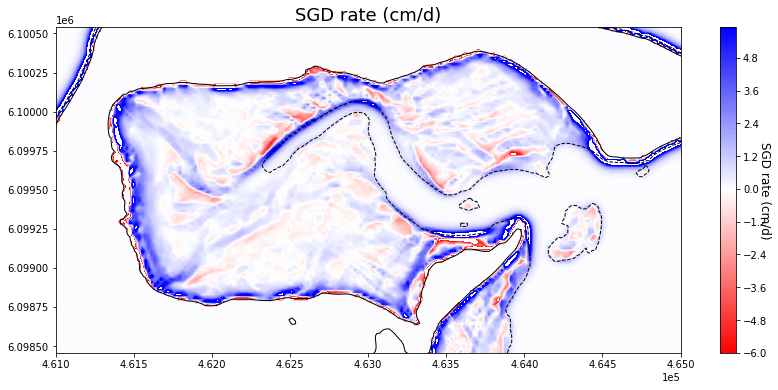

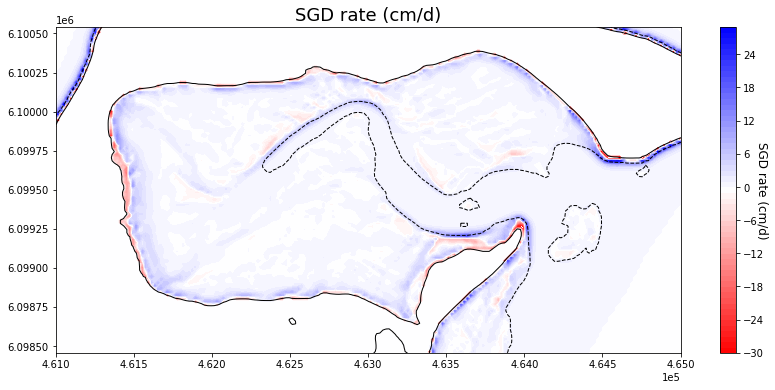

In [84]:
cbb = flopy.utils.binaryfile.CellBudgetFile(model_name+'/' + model_name + '.cbc')
#kstpkper_list = cbb.get_kstpkper()
#cbb.list_records()
ghb_flow = cbb.get_data(text='HEAD DEP BOUNDS',full3D=True) # read from budget file

SGD=-ghb_flow[0].data[0,:,:]/(dx*dy)*100 # in cm/d, positive is discharge, negative is recharge

plt.figure(1, figsize=(14, 6))
cont=plt.contourf(X,Y,SGD,np.arange(-6,6,6.0e-2),cmap='bwr_r')
cbar=plt.colorbar()
cbar.set_label('SGD rate (cm/d)', rotation=270,fontsize=12)
plt.contour(X,Y,top,np.arange(0.9,0.91,0.1),colors='k',linewidths=1.0) ## high water line
plt.contour(X,Y,top,np.arange(-0.9,-0.91,-0.1),colors='k',linewidths=1.0,linestyles='--') ## low water line
plt.title('SGD rate (cm/d)',fontsize=18)
plt.axis('equal')
plt.xlim(4.61e5,4.65e5)
plt.ylim(6.0985e6,6.1005e6)

plt.figure(2, figsize=(14, 6))
cont=plt.contourf(X,Y,SGD,np.arange(-30,30,1),cmap='bwr_r')
cbar=plt.colorbar()
cbar.set_label('SGD rate (cm/d)', rotation=270,fontsize=12)
plt.contour(X,Y,top,np.arange(0.9,0.91,0.1),colors='k',linewidths=1.0) ## high water line
plt.contour(X,Y,top,np.arange(-0.9,-0.91,-0.1),colors='k',linewidths=1.0,linestyles='--') ## low water line
plt.title('SGD rate (cm/d)',fontsize=18)
plt.axis('equal')
plt.xlim(4.61e5,4.65e5)
plt.ylim(6.0985e6,6.1005e6)

### Discussion on modelled SGD

+ Slight morphological undulation in intertidal zone already leads to complex infiltration and exfiltration patterns (upper figure), even with a homogenous permeability
+ Morphology is not invariant in time
+ Problems close to high tide line: locally highly undulating topography and higher beach slopes lead to high in- and exfiltration rates (lower figure)
+ Not clear how we cope with that, of if that matters